<a href="https://colab.research.google.com/github/lukeolson/imperial-multigrid/blob/master/lecture-3-amg-basics/16-aggregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import scipy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

%matplotlib inline

import pyamg
import matplotlib as mplt

### Start with a structured matrix

In [4]:
sten = np.array([[-1.,-1,-1],[-1,8,-1],[-1,-1,-1]])
nx = 10
ny = nx
A = pyamg.gallery.stencil_grid(sten, (nx, ny), format='csr')

#### Form strength (`C`) and aggregation

Here we have 
- `C` represents the strong connections in the graph of `A`
- `AggOp` encodes the aggregate / dof mapping
- `Cpts` label the "root" points of the aggregate

In [5]:
C = pyamg.strength.symmetric_strength_of_connection(A)
AggOp, Cpts = pyamg.aggregation.aggregate.standard_aggregation(C)

In [6]:
AggOp

<100x16 sparse matrix of type '<class 'numpy.int8'>'
	with 100 stored elements in Compressed Sparse Row format>

### Plot it

In [10]:
X, Y = np.meshgrid(np.linspace(0,1,nx), np.linspace(0,1,ny))
V = np.vstack((X.ravel(), Y.ravel())).T
E = np.vstack((A.tocoo().row,A.tocoo().col)).T  # edges of the matrix graph

In [11]:
inner_edges = AggOp.indices[E[:,0]] == AggOp.indices[E[:,1]]
outer_edges = ~inner_edges

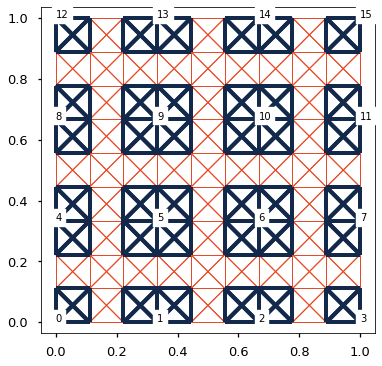

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))

# non aggregate edges
nonaggs = V[E[outer_edges].ravel(),:].reshape((-1, 2, 2))
col = mplt.collections.LineCollection(nonaggs,
                                      color=[232.0/255, 74.0/255, 39.0/255],
                                      linewidth=1.0)
ax.add_collection(col, autolim=True)

# aggregate edges
aggs = V[E[inner_edges].ravel(),:].reshape((-1, 2, 2))
col = mplt.collections.LineCollection(aggs,
                                      color=[19.0/255, 41.0/255, 75.0/255],
                                      linewidth=4.0)
ax.add_collection(col, autolim=True)

ax.autoscale_view()
ax.axis('equal')

for i,c in enumerate(Cpts):
    plt.text(V[c,0], V[c,1], f'{i}',
             backgroundcolor='w')    

### Try an unstructured graph

In [15]:
data = pyamg.gallery.load_example('unit_square')
A = data['A'].tocsr()                              # matrix
V = data['vertices'][:A.shape[0]]                  # vertices of each variable
E = np.vstack((A.tocoo().row,A.tocoo().col)).T  # edges of the matrix graph

In [16]:
C = pyamg.strength.symmetric_strength_of_connection(A)
AggOp, Cpts = pyamg.aggregation.aggregate.standard_aggregation(C)

In [17]:
inner_edges = AggOp.indices[E[:,0]] == AggOp.indices[E[:,1]]
outer_edges = ~inner_edges

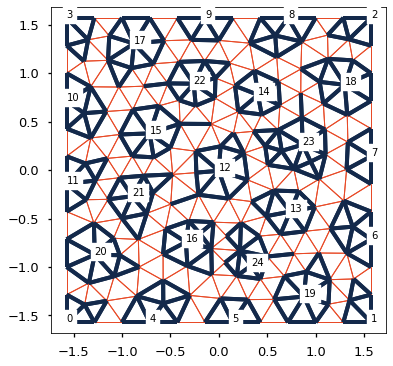

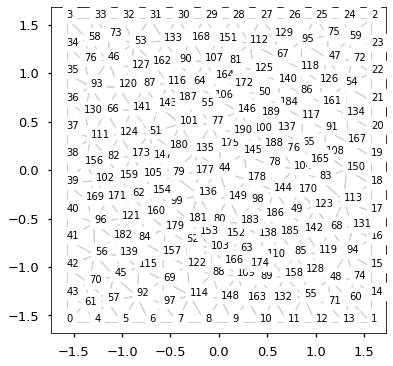

In [33]:
fig, ax = plt.subplots(figsize=(6, 6))

# non aggregate edges
nonaggs = V[E[outer_edges].ravel(),:].reshape((-1, 2, 2))
col = mplt.collections.LineCollection(nonaggs,
                                      color=[232.0/255, 74.0/255, 39.0/255],
                                      linewidth=1.0)
ax.add_collection(col, autolim=True)

# aggregate edges
aggs = V[E[inner_edges].ravel(),:].reshape((-1, 2, 2))
col = mplt.collections.LineCollection(aggs,
                                      color=[19.0/255, 41.0/255, 75.0/255],
                                      linewidth=4.0)
ax.add_collection(col, autolim=True)

ax.autoscale_view()
ax.axis('equal')

for i,c in enumerate(Cpts):
    plt.text(V[c,0], V[c,1], f'{i}',
             backgroundcolor='w')   
    
fig, ax = plt.subplots(figsize=(6, 6))
alledges = V[E[:].ravel(),:].reshape((-1, 2, 2))
col = mplt.collections.LineCollection(alledges,
                                      color='0.8',
                                      linewidth=1.0)
ax.add_collection(col, autolim=True)
ax.autoscale_view()
ax.axis('equal')
for i in range(V.shape[0]):
    plt.text(V[i,0], V[i,1], f'{i}',
             backgroundcolor='w')

### CF Splittings vs Aggregation

In [19]:
data = pyamg.gallery.load_example('unit_square')
A = data['A'].tocsr()                              # matrix
V = data['vertices'][:A.shape[0]]                  # vertices of each variable
E = np.vstack((A.tocoo().row,A.tocoo().col)).T  # edges of the matrix graph

multilevel_solver
Number of Levels:     4
Operator Complexity:  1.422
Grid Complexity:      1.356
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0          191         1243 [70.35%]
    1           51          407 [23.03%]
    2           14          108 [ 6.11%]
    3            3            9 [ 0.51%]



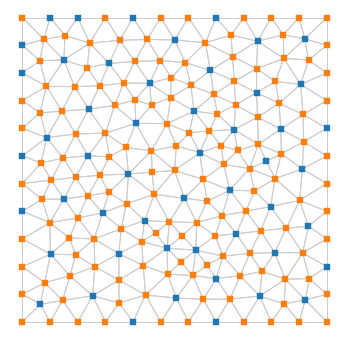

In [39]:
fig, ax = plt.subplots(figsize=(6, 6))
alledges = V[E[:].ravel(),:].reshape((-1, 2, 2))
col = mplt.collections.LineCollection(alledges,
                                      color='0.8',
                                      linewidth=1.0, zorder=-10)
ax.add_collection(col, autolim=True)
ax.autoscale_view()
ax.axis('equal')

# The CF splitting, 1 == C-node and 0 == F-node
ml = pyamg.ruge_stuben_solver(A, keep=True)
splitting = ml.levels[0].splitting
C_nodes = splitting == 1
F_nodes = splitting == 0

plt.scatter(V[C_nodes,0], V[C_nodes,1],
            marker='s',
            s=30.0, label='C pts')
plt.scatter(V[F_nodes,0], V[F_nodes,1],
            marker='s',
            s=30.0, label='F pts')
plt.axis('off')
print(ml)

multilevel_solver
Number of Levels:     3
Operator Complexity:  1.200
Grid Complexity:      1.152
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0          191         1243 [83.31%]
    1           25          233 [15.62%]
    2            4           16 [ 1.07%]



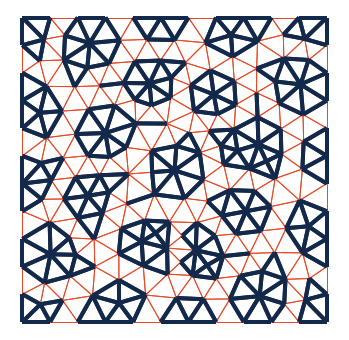

In [41]:
ml = pyamg.smoothed_aggregation_solver(A, keep=True)
AggOp = ml.levels[0].AggOp

inner_edges = AggOp.indices[E[:,0]] == AggOp.indices[E[:,1]]
outer_edges = ~inner_edges

fig, ax = plt.subplots(figsize=(6, 6))

# non aggregate edges
nonaggs = V[E[outer_edges].ravel(),:].reshape((-1, 2, 2))
col = mplt.collections.LineCollection(nonaggs,
                                      color=[232.0/255, 74.0/255, 39.0/255],
                                      linewidth=1.0)
ax.add_collection(col, autolim=True)

# aggregate edges
aggs = V[E[inner_edges].ravel(),:].reshape((-1, 2, 2))
col = mplt.collections.LineCollection(aggs,
                                      color=[19.0/255, 41.0/255, 75.0/255],
                                      linewidth=4.0)
ax.add_collection(col, autolim=True)

ax.autoscale_view()
ax.axis('equal')
ax.axis('off')
print(ml)